<a href="https://colab.research.google.com/github/NajouaMardi/sentiment-analysis/blob/master/app/SentimentA%20(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV


In [ ]:
df = pd.read_csv('sample_labeled_sentiment.csv')
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,full_text,sentiment,confidence
0,1,malware,mcaffee IS malware,[],B07BFS3G7P,B0BQSK9QCF,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2019-07-03 19:37:12.076,0,False,malware. mcaffee IS malware,negative,0.999740
1,5,Lots of Fun,I love playing tapped out because it is fun to...,[],B00CTQ6SIG,B00CTQ6SIG,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-02-16 20:58:56.000,0,True,Lots of Fun. I love playing tapped out because...,positive,0.999827
2,5,Light Up The Dark,I love this flashlight app! It really illumin...,[],B0066WJLU6,B0066WJLU6,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2013-03-04 12:14:27.000,0,True,Light Up The Dark. I love this flashlight app!...,positive,0.999873
3,4,Fun game,One of my favorite games,[],B00KCYMAWK,B00KCYMAWK,AH6CATODIVPVUOJEWHRSRCSKAOHA,2019-06-20 20:10:28.662,0,True,Fun game. One of my favorite games,positive,0.999882
4,4,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,[],B00P1RK566,B00P1RK566,AEINY4XOINMMJCK5GZ3M6MMHBN6A,2014-12-11 00:19:56.000,0,True,I am not that good at it but my kids are. Cute...,positive,0.999729


In [ ]:
print("shape ",df.shape)
print("checking if data is missing",df.isnull().sum())
print("data types of columns",df.dtypes)

shape  (100000, 13)
checking if data is missing rating                0
title                42
text                 48
images                0
asin                  0
parent_asin           0
user_id               0
timestamp             0
helpful_vote          0
verified_purchase     0
full_text             0
sentiment             0
confidence            0
dtype: int64
data types of columns rating                 int64
title                 object
text                  object
images                object
asin                  object
parent_asin           object
user_id               object
timestamp             object
helpful_vote           int64
verified_purchase       bool
full_text             object
sentiment             object
confidence           float64
dtype: object


In [ ]:
#to drop empty lines with empty text or title
df_clean = df.dropna(subset=['title', 'text'])

In [ ]:
print("shape after cleaning ",df_clean.shape)
print("checking if data is missing now",df_clean.isnull().sum())

shape after cleaning  (99923, 13)
checking if data is missing now rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
full_text            0
sentiment            0
confidence           0
dtype: int64


In [ ]:
#Summary statistics for numeric columns
df_clean.describe()

,rating,helpful_vote,confidence
count,99923.000000,99923.000000,99923.000000
mean,3.820842,3.699519,0.982495
std,1.490664,19.697689,0.063335
min,1.000000,0.000000,0.500032
25%,3.000000,0.000000,0.996839
50%,5.000000,0.000000,0.999549
75%,5.000000,2.000000,0.999825
max,5.000000,2091.000000,0.999894


In [ ]:
# Check the value counts of relevant categorical columns (e.g., "rating", "helpfulness")
df_clean['rating'].value_counts()

rating
5    51520
4    15786
1    15345
3    11157
2     6115
Name: count, dtype: int64

In [ ]:
rating_counts = df_clean["rating"].value_counts().sort_index()
rating_percentages = (rating_counts / rating_counts.sum()) * 100

# Display nicely
rating_distribution = pd.DataFrame({
    "count": rating_counts,
    "percentage": rating_percentages.round(2)
})

print(rating_distribution)

        count  percentage
rating                   
1       15345       15.36
2        6115        6.12
3       11157       11.17
4       15786       15.80
5       51520       51.56


<Axes: title={'center': 'Distribution of Ratings'}, xlabel='rating'>

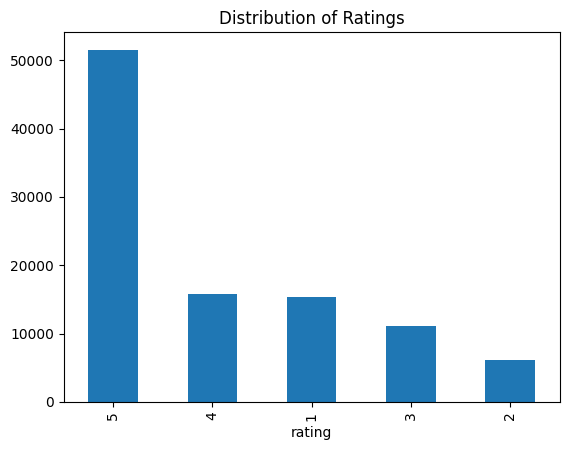

In [ ]:
# If the dataset has a rating column or sentiment labels, explore their distribution
df_clean['rating'].value_counts().plot(kind='bar', title='Distribution of Ratings')

In [ ]:
sentiment_counts = df_clean["sentiment"].value_counts()
sentiment_percentages = (sentiment_counts / len(df)) * 100
sentiment_summary = pd.DataFrame({
    "count": sentiment_counts,
    "percentage": sentiment_percentages.round(2)
})
print(sentiment_summary)

           count  percentage
sentiment                   
positive   65417       65.42
negative   34506       34.51


In [ ]:
'''def label_sentiment(rating):
    if rating > 3:
        return 1  # Positive
    elif rating < 3:
        return 0  # Negative
    else:
        return None  # Neutral, or can drop

df['sentiment'] = df['rating'].apply(label_sentiment)

df = df.dropna(subset=['sentiment'])  # Filter first

# Now set the column using .loc to avoid the warning
df.loc[:, 'sentiment'] = df['sentiment'].astype(int)


In [ ]:
###Text preprocessing (applied on titlz and text):
 ##Lowercase the text
 ##Remove punctuation and non-alphabetic characters
 ##Remove stop words
 ##Apply stemming (get the root of words flies -> fly)

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stop words
    tokens = [word for word in text.split() if word not in stop_words]
    # Stemming
    stemmed = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed)

# Apply to full_text (title+text)
df_clean['clean_full_text'] = df_clean['full_text'].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipykernel_57/2838239324.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['clean_full_text'] = df_clean['full_text'].apply(preprocess)


In [ ]:
df_clean[:50]

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,full_text,sentiment,confidence,clean_full_text
0,1,malware,mcaffee IS malware,[],B07BFS3G7P,B0BQSK9QCF,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2019-07-03 19:37:12.076,0,False,malware. mcaffee IS malware,negative,0.999740,malwar mcaffe malwar
1,5,Lots of Fun,I love playing tapped out because it is fun to...,[],B00CTQ6SIG,B00CTQ6SIG,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-02-16 20:58:56.000,0,True,Lots of Fun. I love playing tapped out because...,positive,0.999827,lot fun love play tap fun watch town grow earn...
2,5,Light Up The Dark,I love this flashlight app! It really illumin...,[],B0066WJLU6,B0066WJLU6,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2013-03-04 12:14:27.000,0,True,Light Up The Dark. I love this flashlight app!...,positive,0.999873,light dark love flashlight app realli illumin ...
3,4,Fun game,One of my favorite games,[],B00KCYMAWK,B00KCYMAWK,AH6CATODIVPVUOJEWHRSRCSKAOHA,2019-06-20 20:10:28.662,0,True,Fun game. One of my favorite games,positive,0.999882,fun game one favorit game
4,4,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,[],B00P1RK566,B00P1RK566,AEINY4XOINMMJCK5GZ3M6MMHBN6A,2014-12-11 00:19:56.000,0,True,I am not that good at it but my kids are. Cute...,positive,0.999729,good kid cute game good kid love nik wallenda
5,4,good game,"Made me think , variety of the puzzles kept it...",[],B00CWY76CC,B00CWY76CC,AEINY4XOINMMJCK5GZ3M6MMHBN6A,2013-07-28 06:53:07.000,0,True,"good game. Made me think , variety of the puzz...",positive,0.999838,good game made think varieti puzzl kept fun pl...
6,5,My favorite showVoice my favorite show,See the voice anytime my My favorite show,[],B018IOV40E,B018IOV40E,AEJDETWITK2KGACH7FUBMY33PPSQ,2018-03-07 20:56:00.247,0,True,My favorite showVoice my favorite show. See th...,positive,0.988742,favorit showvoic favorit show see voic anytim ...
7,5,Great Antivirus product,Not sure what else can be said about Norton pr...,[],B00EZPXYP4,B00EZPXYP4,AFSKPY37N3C43SOI5IEXEK5JSIYA,2013-11-13 15:55:13.000,0,False,Great Antivirus product. Not sure what else ca...,negative,0.833202,great antiviru product sure els said norton pr...
8,1,Fraught with too many problems,Save your money and purchase a good (i.e. Nort...,[],B002I7PGT8,B002I7PGT8,AFSKPY37N3C43SOI5IEXEK5JSIYA,2013-04-19 13:38:15.000,0,False,Fraught with too many problems. Save your mone...,negative,0.999394,fraught mani problem save money purchas good i...
9,4,Norton Internet Security,I always use Norton as my PC security applicat...,[],B0040GFFGO,B005ZKC4FO,AFSKPY37N3C43SOI5IEXEK5JSIYA,2013-04-11 09:08:23.000,0,False,Norton Internet Security. I always use Norton ...,negative,0.609550,norton internet secur alway use norton pc secu...


In [ ]:
###Feature exctraction (vectorization) we will use TF-IDF
###Captures how important a word is in a document relative to the whole corpus
###we will Concatenate the cleaned title and text into one new column
###then apply TF-IDF on the concatenated text.

In [ ]:
#concatenate the cleaned title and text columns into one
#df['clean_combined'] = df['clean_title'] + ' ' + df['clean_text']

#check the first few rows to ensure everything looks good
#print(df[['clean_title', 'clean_text', 'clean_combined']].head())

  clean_title                                         clean_text  \
0      malwar                                      mcaffe malwar   
1     lot fun  love play tap fun watch town grow earn money b...   
2  light dark  love flashlight app realli illumin dark cool g...   
3    fun game                                   one favorit game   
4    good kid               cute game good kid love nik wallenda   

                                      clean_combined  
0                               malwar mcaffe malwar  
1  lot fun love play tap fun watch town grow earn...  
2  light dark love flashlight app realli illumin ...  
3                          fun game one favorit game  
4      good kid cute game good kid love nik wallenda  


In [ ]:

# Initialize the TF-IDF Vectorizer
#tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Fit and transform the 'clean_combined' column to get the TF-IDF features
#X = tfidf_vectorizer.fit_transform(df_clean['clean_full_text'])

# Convert the result into a DataFrame for easier inspection
#X_df = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Check the result
#print(X_df.head())


   abandon  abbyy  abc  abil  abl  aboutbr  abruptli  absolut  abus   ac  ...  \
0      0.0    0.0  0.0   0.0  0.0      0.0       0.0      0.0   0.0  0.0  ...   
1      0.0    0.0  0.0   0.0  0.0      0.0       0.0      0.0   0.0  0.0  ...   
2      0.0    0.0  0.0   0.0  0.0      0.0       0.0      0.0   0.0  0.0  ...   
3      0.0    0.0  0.0   0.0  0.0      0.0       0.0      0.0   0.0  0.0  ...   
4      0.0    0.0  0.0   0.0  0.0      0.0       0.0      0.0   0.0  0.0  ...   

   zilla  zip  zoho  zombi  zone  zonelab  zoo  zoom  zss  zynga  
0    0.0  0.0   0.0    0.0   0.0      0.0  0.0   0.0  0.0    0.0  
1    0.0  0.0   0.0    0.0   0.0      0.0  0.0   0.0  0.0    0.0  
2    0.0  0.0   0.0    0.0   0.0      0.0  0.0   0.0  0.0    0.0  
3    0.0  0.0   0.0    0.0   0.0      0.0  0.0   0.0  0.0    0.0  
4    0.0  0.0   0.0    0.0   0.0      0.0  0.0   0.0  0.0    0.0  

[5 rows x 5000 columns]


In [ ]:
###Next is feature selection
####PCA (Principal Component Analysis): This can help reduce the dimensionality of the data by keeping the most important features.

###Chi-Squared Test (chi²): A statistical test that can be used to evaluate the importance of each feature for classification.

In [ ]:
#assume X is your TF-IDF matrix, and y is your sentiment labels
#max_features=5000 -> Keep only the 10,000 most frequent words (tokens) across all texts.
#or None to keep all
#vectorizer = TfidfVectorizer(max_features=5000)
#X = vectorizer.fit_transform(df['clean_combined'])


In [ ]:
#y = df['sentiment']



In [ ]:
#Example : The k=2000 in SelectKBest(chi2, k=2000) means
#Keep only the top 2,000 features (words/terms) that are most strongly associated with the target (sentiment) according to the Chi-Square test.

In [ ]:

'''pipeline = Pipeline([
    ('chi2', SelectKBest(score_func=chi2)),
    ('clf', LinearSVC())
])

#Grid search on both 'k' of "chi-squared" and SVM hyper-parameters
param_grid = {
    'chi2__k': [1000, 2000, 3000],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__max_iter': [1000, 3000]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1) #n_jobs controls parallelism (how many CPU cores to use)/-1 means use all available cores (maximum speed 🚀)
grid.fit(X, y)

print("Best k (features):", grid.best_params_['chi2__k'])
print("Best C:", grid.best_params_['clf__C'])
print("Best score:", grid.best_score_)


Best k (features): 1000
Best C: 1
Best score: 0.8843014176160559


In [ ]:

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # no max_features set here, let grid search handle it
    ('chi2', SelectKBest(score_func=chi2)),
    ('clf', LinearSVC())
])

param_grid = {
    'tfidf__max_features': [4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'chi2__k': [2000, 3000],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__max_iter': [1000, 3000]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=1)
grid.fit(df_clean['clean_full_text'], df_clean['sentiment'])

print("Best max_features (TF-IDF):", grid.best_params_['tfidf__max_features'])
print("Best ngram_range (TF-IDF):", grid.best_params_['tfidf__ngram_range'])
print("Best k (SelectKBest):", grid.best_params_['chi2__k'])
print("Best C (LinearSVC):", grid.best_params_['clf__C'])
print("Best score:", grid.best_score_)



In [ ]:
df = pd.read_csv('C:\Users\youga\Downloads\sample_labeled_sentiment.csv')
df.head()